You need to install colossus, bigfile (https://github.com/rainwoodman/bigfile) in the jupyter kernel environment before running this notebook. All can be done with pip install.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

# sns.set()
sns.set_palette("Set2")
# sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import matplotlib as mpl

In [3]:
snap=483


pig2 = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%snap)

# you can check the redshift by reading the attributes of the snapshot
battr = pig2["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------ cosmological parameters -----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


# set-up cosmology
params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
cosmo = cosmology.setCosmology('myCosmo', params)

# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------ cosmological parameters -----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


### Subhalo in Groups

In [38]:
gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

In [39]:
nsubs_all = NSubs[:]

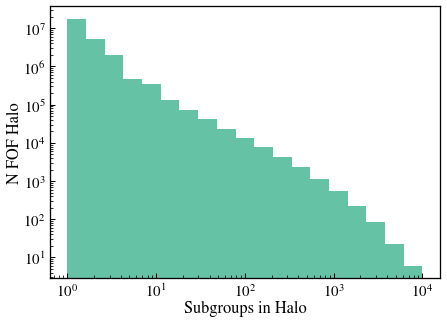

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(nsubs_all, bins = np.logspace(0, 4, 20))
ax.set(xscale="log", yscale="log", ylabel="N FOF Halo", xlabel="Subgroups in Halo")
plt.yscale('log')
plt.xscale('log')
# plt.xlabel('Nsubgroup')
# plt.ylabel('Ngroup')


plt.show()

### BH-galaxy relation

In [41]:
# the most basic cut on stellar mass and Nbh
ngal = int(1e7) # this is sufficient
nbh = int(1e8)
#------------- Load data ------------------
gal_mass = sMass[:ngal][:,4] * 1e10/hh
sublen5 = sLength[:ngal][:, 5]

# select galaxies with stellar mass > 1e8
mask = gal_mass > 1e8
mask &= sublen5 > 0
gal_mass = gal_mass[mask]
sublen5 = sublen5[mask]
gal_nbh = sublen5

# other fields

gal_sfr = pig2['SubGroups/SubhaloSFR'][:ngal][mask]
gal_rhalf = pig2['SubGroups/SubhaloHalfmassRadType'][:ngal][mask, 4] * scale_fac # rhalf in ckpc/h for z=2 subfind

msfof = pig2['FOFGroups/MassByType'][:ngal][mask, 4] * 1e10 / hh
suboff5 = sOffset[:ngal][mask, 5]
suboff4 = sOffset[:ngal][mask, 4]
sublen4 = sLength[:ngal][mask, 4]

gal_ssfr = gal_sfr/gal_mass


print(len(gal_mass))
ind = mask.nonzero()[0]
print(len(ind))

Ninit = len(ind)


636732
636732


In [25]:
# load BH properties
bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
bhgroup = pig2['5/GroupID'][:nbh] - 1
bhid = pig2['5/ID'][:nbh]

# find total BH mass in this galaxy
gal_m5 = np.array([np.sum(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])

# group index of this galaxy
gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
# FOF halo mass of this galaxy
gal_gmass = np.array([msfof[i] for i in gal_gidx])
# Central BH mass of this galaxy
gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
# central BH index for fetching other central BH properties
cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


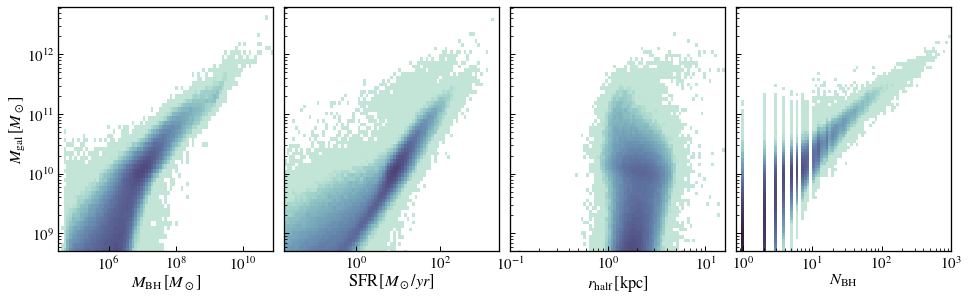

In [42]:
# Make some plots

cc = sns.cubehelix_palette(as_cmap=True)
cc2 = sns.cubehelix_palette(as_cmap=True,rot=-.4)
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

fig, ax = plt.subplots(1,4,figsize=(16,4.5), sharey=True)
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()


# ---------------- Mgal_Mbh -------------------------
# mask1 = gal_m5 > gal_mass/10
# mask2 = (gal_mass > gal_m5 * 5000)
# mask2 &= gal_mass > 1e11 

# mask = ~(mask1 | mask2)
mask = gal_mass > 3e7


xmin, xmax = 4.5, 10.9
ymin, ymax = 7., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[0].hist2d(gal_m5[mask], gal_mass[mask], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[0].set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[0].set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')



# ---------------- Mgal_sfr -------------------------
xmin, xmax = -1.7, 3.4
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80) 
ybins = np.logspace(ymin,ymax, 80)
ax[1].hist2d(gal_sfr, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[1].set(xscale='log', yscale='log',xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[1].set(xlabel=r'${\rm SFR}\,[M_\odot/yr]$')
ax[1].legend(markerscale=20)
# legend.legendHandles[0]._legmarker.set_markersize(15)

# ---------------- Mgal_reff -------------------------
xmin, xmax = -1, 1.2
ymin, ymax = 8., 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[2].hist2d(gal_rhalf, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))

ax[2].set(xscale='log', yscale='log', xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[2].set(xlabel=r'$r_{\rm half}\,[{\rm kpc}]$')



# ---------------- Mgal_Nbh -------------------------
xmin, xmax = -0.1, 3.
ymin, ymax = 8.7, 12.8

xbins = np.logspace(xmin,xmax, 80)
ybins = np.logspace(ymin,ymax, 80)
ax[3].hist2d(gal_nbh, gal_mass, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=20, vmax=8000))


ax[3].set(xscale='log', yscale='log',xlim=[10**xmin, 10**xmax], ylim=[10**ymin, 10**ymax])
ax[3].set(xlabel=r'$N_{\rm BH}$')
ax[3].legend()

#plt.savefig('z2_population_selection.png', bbox_inches='tight', dpi=140, facecolor='white', transparent=False)

plt.show()


#### Locate BHs in subgroups

In [27]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 5e5)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

3937662


In [28]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:]
suboff5 = suboff[:,5]
del suboff

In [29]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

In [30]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1

In [31]:
def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

3937662
0
218
[[       0        0        0        0        0        0]
 [29762623 31694496        0        0  5236942     1439]]
[[29762623 31694496        0        0  5236942     1439]
 [ 3842076  5011266        0        0  2429209      364]]
[29762623 31694496        0        0  5236942     1439]
[0 0 0 0 0 0] [29762623 31694496        0        0  5236942     1439]


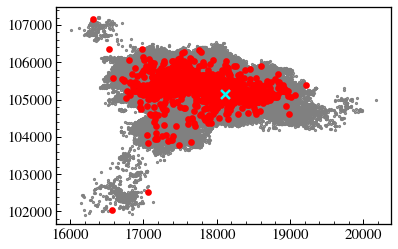

In [32]:

blist = bidxlist
slist = sidxlist
print(len(blist))


sidx = slist[16]
print(sidx)
print(blist[16])

soff = pig2['SubGroups/SubhaloOffsetType'][sidx]
slen = pig2['SubGroups/SubhaloLenType'][sidx]


print(pig2['SubGroups/SubhaloOffsetType'][sidx:sidx+2])
print(pig2['SubGroups/SubhaloLenType'][sidx:sidx+2])
sbeg,send = soff, soff + slen
print(slen)
print(sbeg,send)
pos5 = pig2['5/Position'][sbeg[5]:send[5]]
pos4 = pig2['4/Position'][sbeg[4]:send[4]]
# pos1 = pig2['1/Position'][sbeg[1]:send[1]]


center = pig2['SubGroups/SubhaloPos'][sidx]

plt.scatter(pos4[:,0],pos4[:,1],s=1,color='grey')
# plt.scatter(pos1[:,0],pos1[:,1],s=1,color='grey')
plt.scatter(pos5[:,0],pos5[:,1],s=20,color='red')
plt.scatter(center[0],center[1],marker='x',color='cyan',s=80)
plt.show()

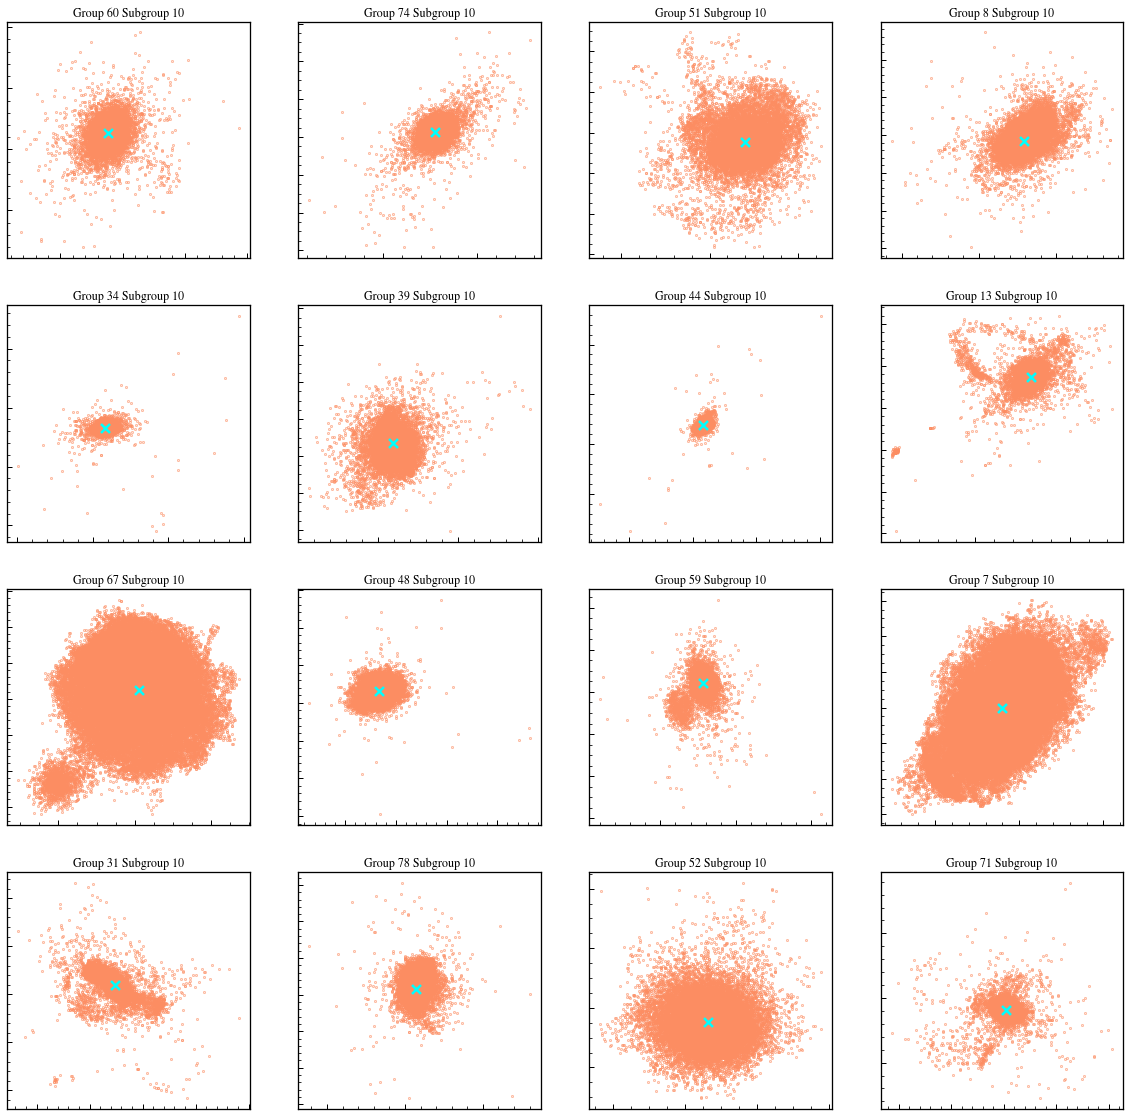

In [33]:
p = 4
gidx = 3
isub = 10

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.random.choice(range(1,80), 16, replace=False)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    

    sstart = sOffset[sidx]
    send   = sOffset[sidx] + sLength[sidx]

    m1 = sMass[sidx][4]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
# plt.savefig('test_sub0.png',bbox_inches='tight')
plt.show()